<a href="https://colab.research.google.com/github/SaeedTafazzol/digit_generator/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cuda


/tmp/ipykernel_22659/3152267275.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  t = F.softmax(t)


100 tensor(1.2454, device='cuda:0', grad_fn=<DivBackward0>)
200 tensor(1.6709, device='cuda:0', grad_fn=<DivBackward0>)
300 tensor(1.9727, device='cuda:0', grad_fn=<DivBackward0>)
400 tensor(1.8395, device='cuda:0', grad_fn=<DivBackward0>)
500 tensor(2.5886, device='cuda:0', grad_fn=<DivBackward0>)
600 tensor(2.0448, device='cuda:0', grad_fn=<DivBackward0>)
700 tensor(1.3725, device='cuda:0', grad_fn=<DivBackward0>)
800 tensor(4.7251, device='cuda:0', grad_fn=<DivBackward0>)
900 tensor(1.7165, device='cuda:0', grad_fn=<DivBackward0>)
1000 tensor(1.5373, device='cuda:0', grad_fn=<DivBackward0>)
1100 tensor(1.0860, device='cuda:0', grad_fn=<DivBackward0>)
1200 tensor(1.4768, device='cuda:0', grad_fn=<DivBackward0>)
1300 tensor(1.4847, device='cuda:0', grad_fn=<DivBackward0>)
1400 tensor(1.1073, device='cuda:0', grad_fn=<DivBackward0>)
1500 tensor(0.9814, device='cuda:0', grad_fn=<DivBackward0>)
1600 tensor(1.1313, device='cuda:0', grad_fn=<DivBackward0>)
1700 tensor(1.1497, device='cuda:

/tmp/ipykernel_22659/3152267275.py:194: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(r1))
/tmp/ipykernel_22659/3152267275.py:199: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(gan.disc(img)))


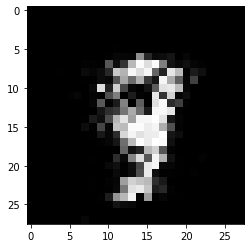

In [ ]:
# -*- coding: utf-8 -*-
"""gan.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1B0ENiczKUwNOizE-3Q-2oy4YxjBC-kW8
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from matplotlib import pyplot as plt



transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5),   # 3 for RGB channels
                                     std=(0.5))])


dataset1 = datasets.MNIST('../data', train=True,transform=transform, download=True)
dataset2 = datasets.MNIST('../data', train=False,transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2,batch_size=64, shuffle=True)

i = 600
#plt.imshow(dataset1[i][0].squeeze(),cmap='gray')
#print(dataset1[i][0].reshape(-1,28*28))
# a= torch.zeros((64),dtype = torch.bool)
# print(a)
# print(a.int())

z = 2 
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.l1 = nn.Linear(28*28,128)
    self.l2 = nn.Linear(128,64)
    self.l3 = nn.Linear(64,64)
    self.l4 = nn.Linear(64,2)

  def forward(self, img):
    img = img.reshape(-1,28*28)
    out = F.leaky_relu(self.l1(img),0.2)
    out = F.leaky_relu(self.l2(out),0.2)
    out = F.leaky_relu(self.l3(out),0.2)
    out = self.l4(out)
    return out
  

def random_gen(batch,n_dim):
  return  2*torch.rand((batch,n_dim)).to(device)-1
  # return  torch.randn((batch,n_dim)).to(device)
def entropy_loss(t):
  t = F.softmax(t)
  # print('t',t)
  entropy = -((t*torch.log(t)).sum(-1)).mean(0)
  # print(entropy)/
  loss = 10*(0.2 - torch.clamp(entropy,max=0.2))
  # print(loss)
  return loss
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.l1 = nn.Linear(z,64)
    self.l2 = nn.Linear(64,64)
    self.l3 = nn.Linear(64,128)
    self.l4 = nn.Linear(128,28*28)
  def forward(self, lat):
    out = F.relu(self.l1(lat))
    out = F.relu(self.l2(out))
    out = F.relu(self.l3(out))
    out = F.tanh(self.l4(out))
    return	out.reshape(-1,1,28,28)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# latent = torch.randn((64,128)).to(device)
# print(latent)

class GAN(object):
  def __init__(self):
    self.gen = Generator().to(device)
    self.gen_op =  torch.optim.Adam(self.gen.parameters(),lr=1e-3)


    self.disc = Discriminator().to(device)
    self.disc_op =  torch.optim.Adam(self.disc.parameters(),lr=1e-3)

  def train_all2(self,data_loader):
    img, label = next(iter(data_loader))
    img = img.to(device)
    # label = label.to(device)

    d = self.disc(img)
    self.disc_op.zero_grad()

    loss = nn.CrossEntropyLoss()(d,torch.ones((d.shape[0],),dtype=torch.long).to(device)) + entropy_loss(d)
    loss.backward()
    
    latent = random_gen(64,z)
    generated = self.gen(latent)
    d = self.disc(generated.detach())
    loss = nn.CrossEntropyLoss()(d,torch.zeros((generated.shape[0],),dtype=torch.long).to(device)) + entropy_loss(d)
    loss.backward()

    self.disc_op.step()


    self.gen_op.zero_grad()
    self.disc_op.zero_grad()

    latent = random_gen(64,z)
    generated = self.gen(latent)
    loss = nn.CrossEntropyLoss()(self.disc(generated),torch.ones((generated.shape[0],),dtype=torch.long).to(device))

    loss.backward()
    self.gen_op.step()
    # idx = torch.randint(0,2,(64,)).to(device)
    # idx  = idx.eq(0)

    # latent = self.encoder(img)
    # print('img',img)
    # print('gene',generated)
    # print('idx',idx)

    # result = torch.cat((torch.zeros((img[idx].shape[0],),dtype=torch.float),torch.ones((generated[~idx].shape[0],),dtype=torch.float))).to(device)
    # result_b = torch.cat((torch.ones((img[idx].shape[0],),dtype=torch.float),torch.zeros((generated[~idx].shape[0],),dtype=torch.float)),dim=0).to(device)
    # print(result)
    # result = result.reshape(-1,1)
    # result_b = result_b.reshape(-1,1)

    # generated = torch.cat((img[idx],generated[~idx]))

    # print('aft',generated)
    # fakeness = self.disc(generated)
    


    
         

    # print(fakeness.shape)
    # print(result_b.shape)
    # loss =  nn.BCELoss()(fakeness,result_b)
    # self.enc_op.zero_grad()
    # self.dec_op.zero_grad()


    # loss.backward()
    # for g in self.encoder.parameters():
    #   print(g.grad)
    # torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), 1)
    # torch.nn.utils.clip_grad_norm_(self.decoder.parameters(), 1)

    # self.dec_op.step()
    # self.enc_op.step()
    # from torch.autograd import Variable
    # fakeness = self.disc(Variable(generated))
    # disc_loss = nn.BCELoss()(fakeness,result)
    # self.disc_op.zero_grad()

    # disc_loss.backward()
    # torch.nn.utils.clip_grad_norm_(self.disc.parameters(), 1)

    # self.disc_op.step()
    
    return loss



gan = GAN()

loss = 0

for i in range(10001):
  loss += gan.train_all2(train_loader)
  if((i+1)%100==0):
    print(i+1,loss/100)
    loss = 0

# i = 100
r1 = gan.disc(dataset1[0][0].to(device))
# plt.imshow(dataset2[i][0].squeeze(),cmap='gray')
print(F.softmax(r1))

with torch.no_grad():
  img = gan.gen(torch.randn((z,)).to(device))
  plt.imshow(((img+1)/2).detach().cpu().squeeze(),cmap='gray')
  print(F.softmax(gan.disc(img)))
  plt.show()


In [ ]:
for i in range(100001):
  loss += gan.train_all2(train_loader)
  if((i+1)%100==0):
    print(i+1,loss/100)
    loss = 0


/tmp/ipykernel_22659/3152267275.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  t = F.softmax(t)


100 tensor(2.0653, device='cuda:0', grad_fn=<DivBackward0>)
200 tensor(2.1512, device='cuda:0', grad_fn=<DivBackward0>)
300 tensor(2.1794, device='cuda:0', grad_fn=<DivBackward0>)
400 tensor(2.2227, device='cuda:0', grad_fn=<DivBackward0>)
500 tensor(2.2082, device='cuda:0', grad_fn=<DivBackward0>)
600 tensor(2.1593, device='cuda:0', grad_fn=<DivBackward0>)
700 tensor(2.0403, device='cuda:0', grad_fn=<DivBackward0>)
800 tensor(2.2191, device='cuda:0', grad_fn=<DivBackward0>)
900 tensor(2.1824, device='cuda:0', grad_fn=<DivBackward0>)
1000 tensor(2.2298, device='cuda:0', grad_fn=<DivBackward0>)
1100 tensor(2.2080, device='cuda:0', grad_fn=<DivBackward0>)
1200 tensor(2.2553, device='cuda:0', grad_fn=<DivBackward0>)
1300 tensor(2.0530, device='cuda:0', grad_fn=<DivBackward0>)
1400 tensor(2.2149, device='cuda:0', grad_fn=<DivBackward0>)
1500 tensor(2.1535, device='cuda:0', grad_fn=<DivBackward0>)
1600 tensor(2.1894, device='cuda:0', grad_fn=<DivBackward0>)
1700 tensor(2.2405, device='cuda:

tensor([[0.9175, 0.0825]], device='cuda:0')


/tmp/ipykernel_22659/3185938730.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(gan.disc(img)))


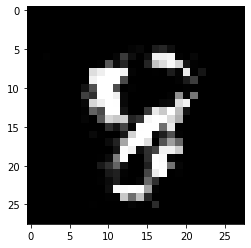

In [ ]:

with torch.no_grad():
  img = gan.gen(torch.randn((z,)).to(device))
  plt.imshow(((img+1)/2).detach().cpu().squeeze(),cmap='gray')
  print(F.softmax(gan.disc(img)))
  plt.show()

tensor([[0.7062, 0.2938]], device='cuda:0')


/tmp/ipykernel_22659/3185938730.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(gan.disc(img)))


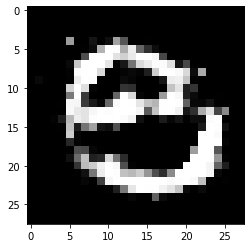

In [ ]:

with torch.no_grad():
  img = gan.gen(torch.randn((z,)).to(device))
  plt.imshow(((img+1)/2).detach().cpu().squeeze(),cmap='gray')
  print(F.softmax(gan.disc(img)))
  plt.show()

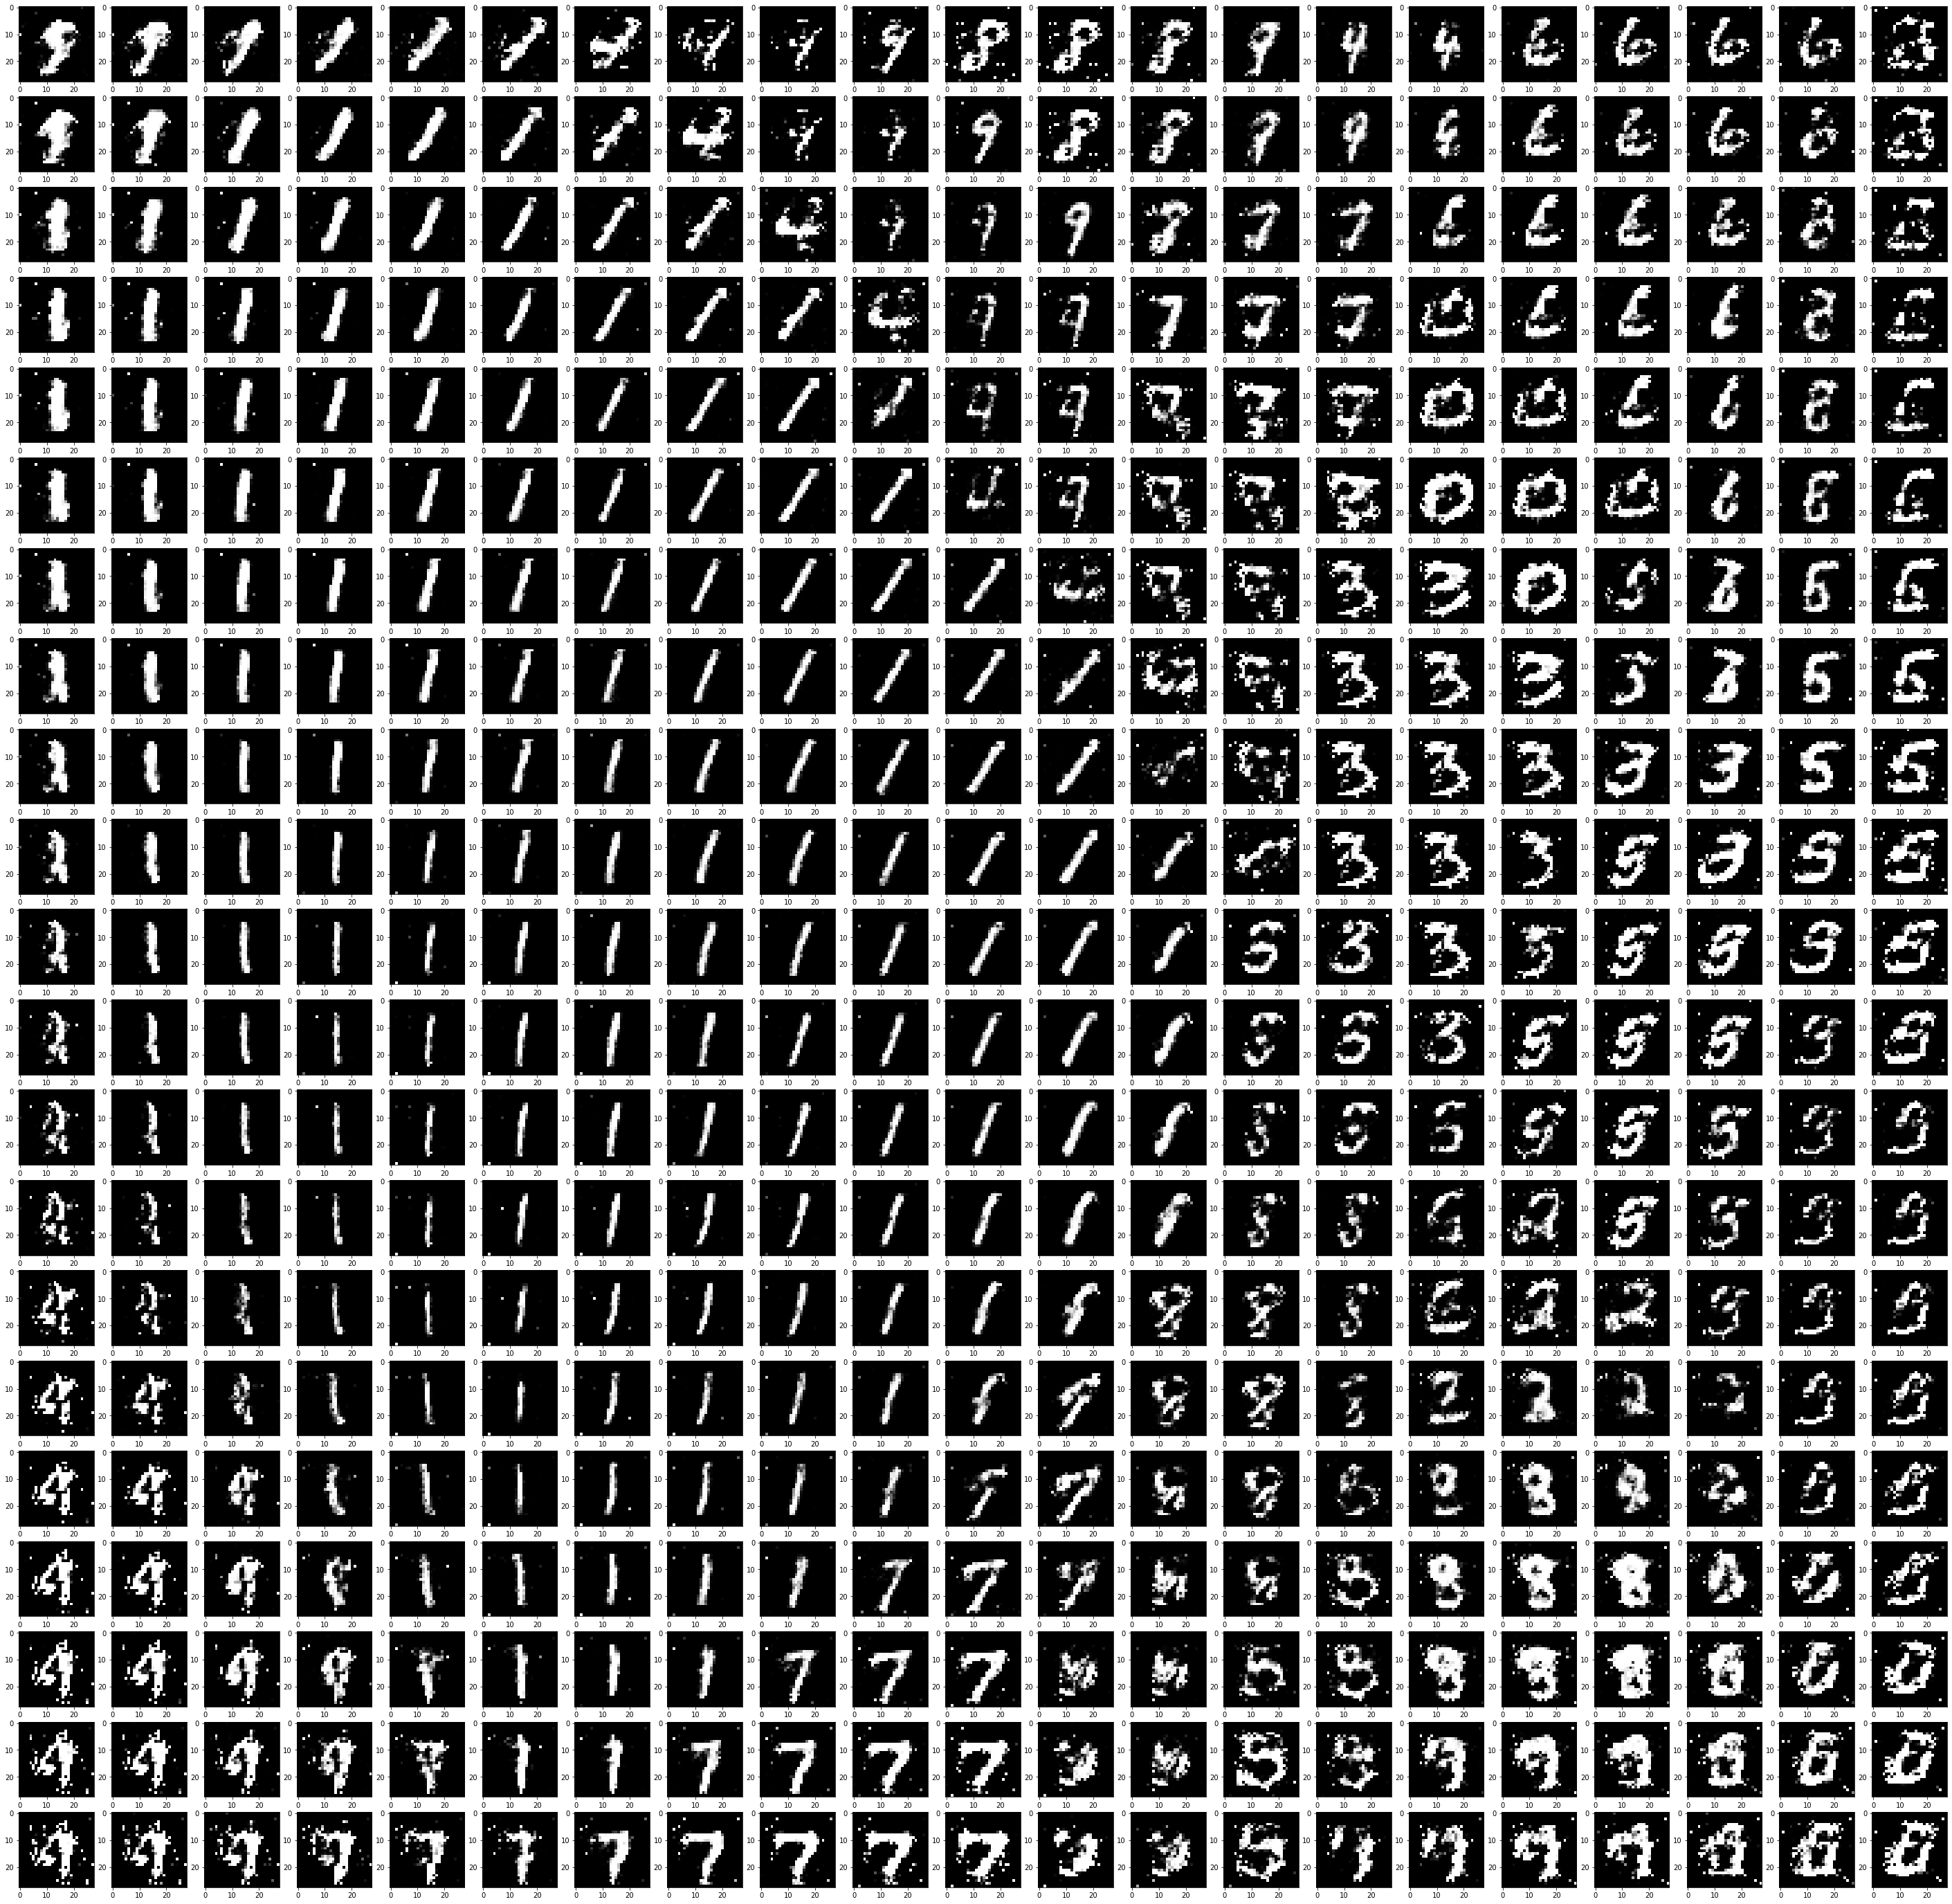

In [ ]:
f, axarr = plt.subplots(21,21)
f.set_figheight(50)
f.set_figwidth(50)

for j in range(21):
  for k in range(21):
    genr = gan.gen(torch.tensor([[j*0.1 -1,k*0.1-1]]).to(device))
    axarr[j,k].imshow(genr.detach().cpu().squeeze(),cmap='gray')


In [ ]:
p = 0.9
a=torch.tensor([[p,1-p],[0.8,0.2]])
-((a*torch.log(a)).sum(-1)).mean(0)

tensor(0.4127)

In [ ]:
a = torch.tensor(1.0)
a.requires_grad = True
(a+ torch.distributions.Normal(0,torch.tensor(1.0)).sample() * a).backward()
a.grad

tensor(1.8531)